<a href="https://colab.research.google.com/github/kellyile/dsi_m4_geo_nlp/blob/main/DSI_M4_Geospatial_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unstructured text and Geospatial NLP
Geospatial data is not only available in the form of maps and feature/imagery layers, but also in form of unstructured text.

Unstructured text is written content that lacks structure and cannot readily be indexed or mapped onto standard database fields. It is often user-generated information such as emails, instant messages, news articles, documents or social media postings. These unstructured documents can contain location information which makes them geospatial information. Mapping information from such documents could be of a great value.

I have developed a geospatial nlp system that is able to extract named entities relating to crime data, namely addresses, crime type, crime date and time, reported date and time, reporting officer and weapon used (Figure 1). 
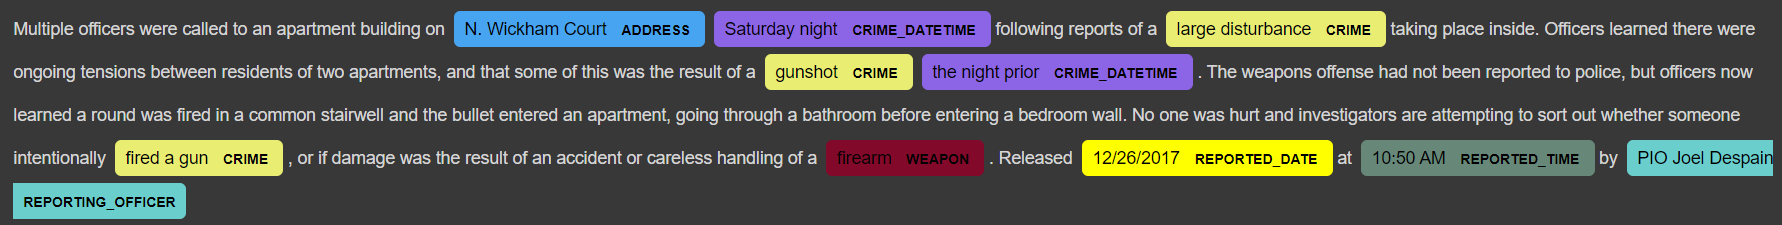

*Figure 1. Named entities extracted from unstructured text*

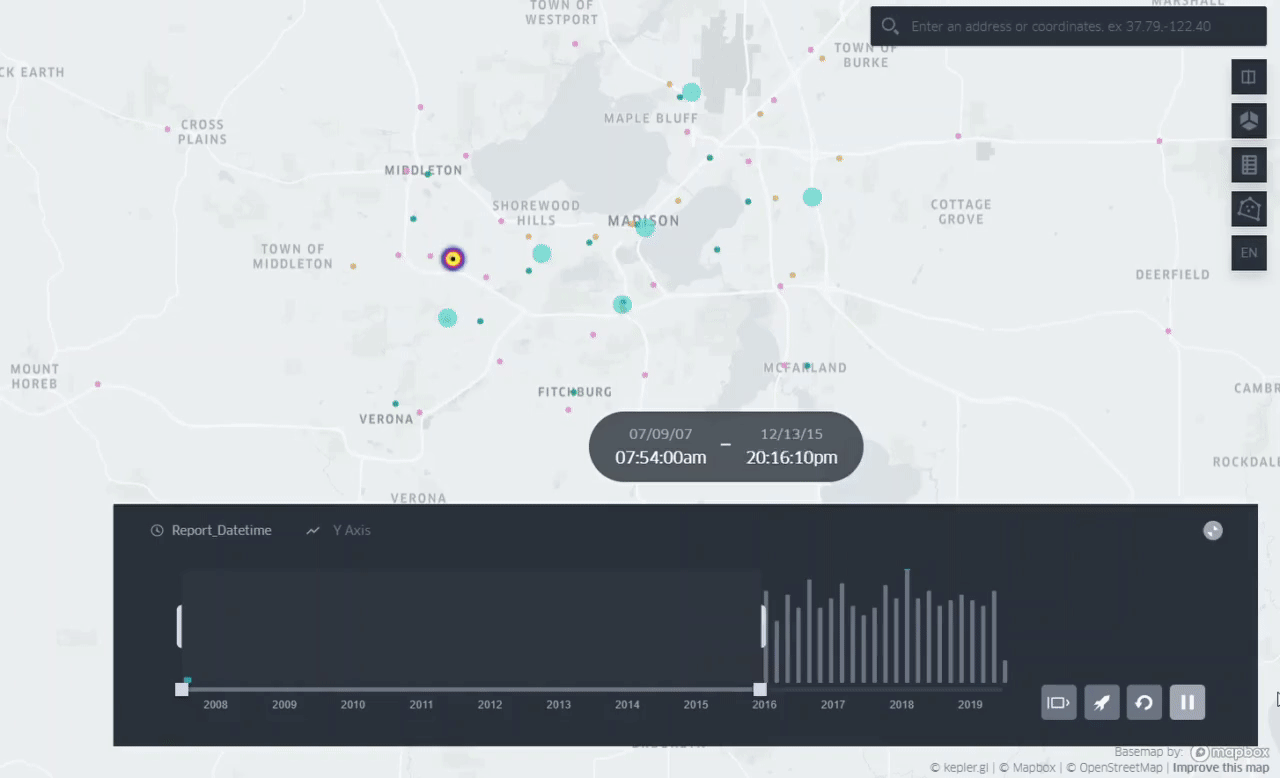

*Figure 2: Geospatial NLP visualisation*

My approach made use of Esris's arcgis learn modeule for natural language processing as well as Uber's keplergl for geospatial mapping, with all of this being implemented in Google Colaboratory. Unstructured text from Madison city, Wisconsin was gathered from Esri's open source portal. The data contained both labelled and unlabelled data for testing and training. The metrics used to evaluate the model were precision, recall & f1-measures.

The aims of this investigation as well as the approach I took to complete this assignment is outlined in the workflow below, and detailed in the subsequent sections of this notebook.

# Aims



1.   Extract locations from unstructured text
2.   Identify crimes from unstructured text
3.   Process the unstructured text documents and display them visually to support insight extraction



#Project Workflow

This section of the report describes the summary of the workflow undertaken to complete this project. 

This project was completed over about two months and began with the obtained data. The data was briefly explored to get a better sense of the amount of data available and the labels that were assigned to the test set.

Due to being a novice on the subject of geospatial nlp there was also a need to learn how string addresses could be geocoded into coordinates (after experiencing a pay wall in using Esri's batch geocoder, other open source geocoders such as *geocoder* and *geopy* were explored). 

Lastly, methods of spatially visualising the gecoded strings had to be explored to ensure an insightful and aestheticlly pleasing cartographic repersentation (this was primarly done through the use of folium and keplergl).

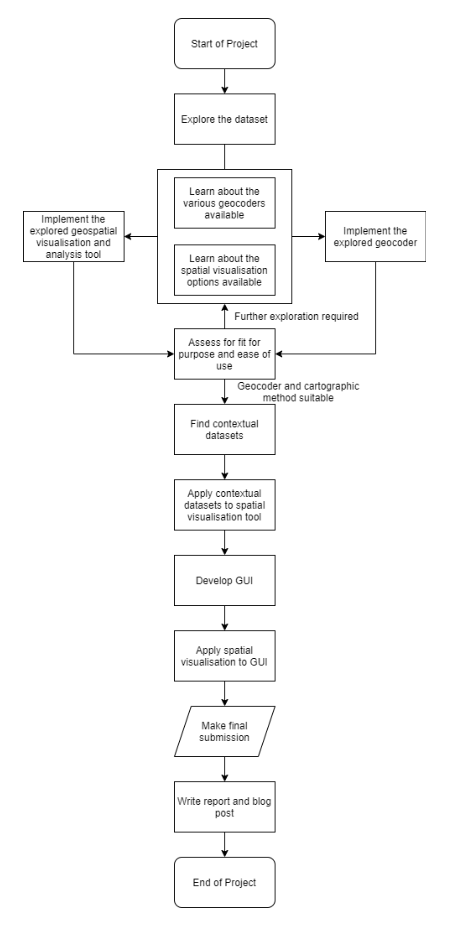

*Figure 3: Diangram of project workflow*

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyngrok==4.1.1
!pip install transformers
!pip install streamlit
!pip install spacy_streamlit
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip install arcgis
!pip install geocoder

  Created wheel for pyngrok: filename=pyngrok-4.1.1-cp36-none-any.whl size=15971 sha256=18a0bc70128ee585898ebba920f181f31bd2cd516bf64dae7da3d25eae6a325d
  Stored in directory: /root/.cache/pip/wheels/97/71/0d/1695f7c8815c0beb3b5d9b35d6eec9243c87e6070fbe3977fa
Successfully built pyngrok
     |████████████████████████████████| 1.8MB 6.0MB/s 
     |████████████████████████████████| 2.9MB 52.2MB/s 
     |████████████████████████████████| 890kB 45.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7ca763a816e3dcf6aedd9b17d557165edac97e66c56ac8cfccfc03e8b6f1d118
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 7.5MB 5.3MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 4.5MB 52.5MB/s 
     |████████████████████████████████| 163kB 44.5MB/s 
     |█████████████████████

     |████████████████████████████████| 12.0MB 1.3MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-cp36-none-any.whl size=12019126 sha256=4addd811a22541b0dae96402a23aa7dc0f04c560b3dfacd7f033d19826aaacd2
  Stored in directory: /root/.cache/pip/wheels/48/5c/1c/15f9d02afc8221a668d2172446dd8467b20cdb9aef80a172a4
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
     |████████████████████████████████| 2.6MB 4.1MB/s 
  Using cached https://files.pythonhosted.org/packages/a1/43/855f655b21e11e3284b46a135bed1e24ca983058b3635a1e99db3b8e24c0/keyring-22.0.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/20/73c8fa29a4ba8f8cbdb037369e6b61ac9253664a8aa0912b52169192447f/lerc-0.1.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/8d/54/2a618356e54282e3f4fa0745cbddeed104ed5ff2930c98f2d9dfa9677af8/ujson-4.0.2-cp36-cp

     |████████████████████████████████| 102kB 3.0MB/s 


In [ ]:
import pyngrok
from pyngrok import ngrok
from PIL import Image
import streamlit as st
import pandas as pd
from datetime import datetime
import random 
import spacy
import geocoder
import folium
from tqdm.notebook import tqdm
from arcgis.gis import GIS
from arcgis.learn import prepare_data, EntityRecognizer

In [ ]:
print(ngrok.__version__)

4.1.1


# NLP Model

## Data exploration (surface-level)

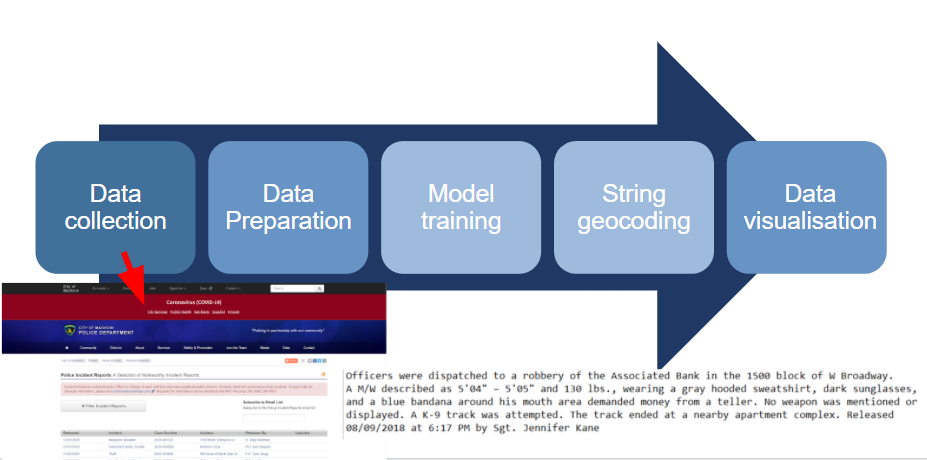

*Figure 4: Data exploration*

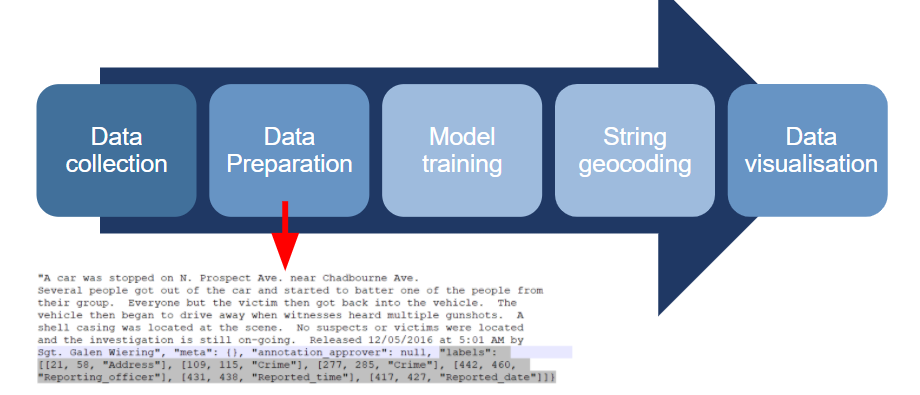

*Figure 5: Data labels*

After collecting the data the it was prepared by running it through Esri's prepare_data() function, which among other things automatically splits the data into training and validations sets. The only specifications necessary are the path to the data, the format the data was labelld in and the label that identifies location.

The training data and their labels were then visualised using data.show_batch()

In [ ]:
json_path = r"/content/drive/MyDrive/information-extraction-from-madison-city-crime-incident-reports-using-deep-learning/labelled_crime_reports.json"

data = prepare_data(path=json_path,
                    class_mapping={'address_tag': 'Address'},
                    dataset_type='ner_json')

data.show_batch()

/usr/local/lib/python3.6/dist-packages/arcgis/learn/models/_arcgis_model.py:336: UserWarning: Cuda is not available
  warnings.warn("Cuda is not available")


,text,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon
0,A Madison mother had her four-year-old son wit...,[3500 block of Anderson St.],[road rage incident],,[01/31/2019],[9:07 AM],[PIO Joel Despain],[crowbar]
1,A knife-wielding woman claimed the man she tri...,"[Capitol Centre Market, 111 N. Broom St.]","[stab, second degree reckless endangerment, be...",,[09/04/2018],[11:08 AM],[PIO Joel Despain],"[knife, nine-inch steak knife]"
2,Members of the Dane County Narcotics Task Forc...,[Badger Road area],"[peddling cocaine and heroin, possession with ...",,[03/12/2019],[12:23 PM],[PIO Joel Despain],[Monday morning]
3,Members of the Dane County Narcotics Task Forc...,[Badger Road area],"[peddling cocaine and heroin, possession with ...",,[03/12/2019],[12:23 PM],[PIO Joel Despain],[Monday morning]
4,Madison Police responded to three different ca...,"[North side of Madison, Crestline Dr, Green Ri...",[windows were shot out],,[10/31/2016],[11:59],[Sgt. Paul Jacobsen],[pellet or soft air gun]
5,The MPD arrested two men last night following ...,"[Alter Metal Recycling, 4400 Sycamore Ave]","[attempted burglary, attempted burglary]",,[03/03/2016],[9:02 AM],[PIO Joel Despain],
6,"A Michigan man, who attempted to swindle the E...",[E. Washington Ave. AT&T store],[attempted to swindle],,[02/17/2016],[12:14 PM],[PIO Joel Despain],
7,Madison Police Officers responded to the 3500 ...,[3500 block of Ridgeway Avenue on Christmas Eve],"[entered their residence, taking all of their ...",[after 7pm],[12/26/2015],[9:43 AM],[P.O. Howard Payne],


Using the Esri EntityRecognizer model (which is built on Spacy), using lr_find() the optimal step size and learning rate for the data is found. The training is done iteratively until the error loss continuously decreases with each epoch and the F1 score (the mean of the accuracy of the model and the models ability to find all positive samples) improves with each pass.

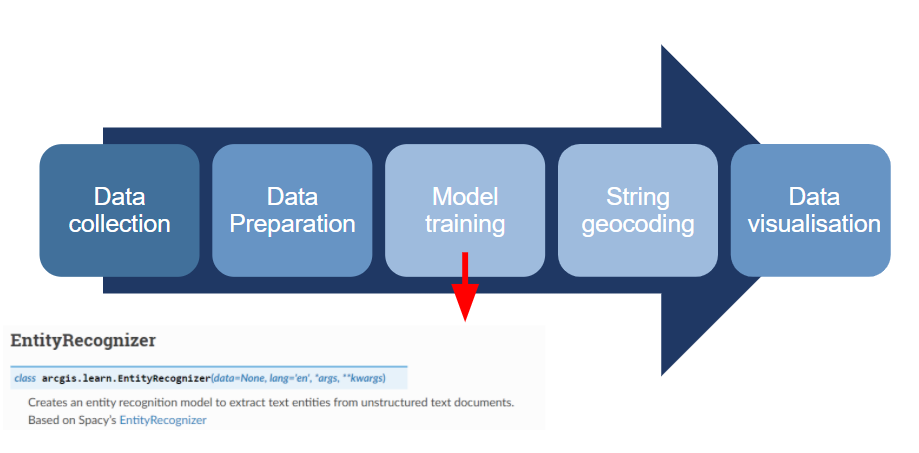

*Figure 6: Model training*

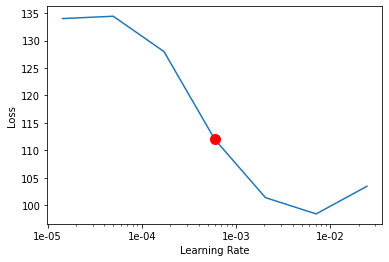

epoch,losses,val_loss,precision_score,recall_score,f1_score,time
0,78.67,10.55,0.0,0.0,0.0,00:00:04
1,17.48,16.34,0.71,0.15,0.24,00:00:04
2,17.69,9.61,0.91,0.4,0.55,00:00:04
3,16.73,9.04,0.83,0.34,0.48,00:00:04
4,15.4,49.67,0.53,0.22,0.32,00:00:04
5,39.58,11.88,0.17,0.03,0.05,00:00:04
6,25.68,15.65,0.59,0.47,0.52,00:00:04
7,30.04,22.02,0.59,0.34,0.43,00:00:04
8,26.46,23.57,0.0,0.0,0.0,00:00:04
9,23.77,24.57,0.15,0.03,0.05,00:00:04


,TEXT,Filename,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon
0,Victim reporting that he was pistol whipped in...,Example_0,3400 block of N Sherman Ave,,,09/18/2017,9:30 PM,Sgt. Rosemarie Mansavage,
1,Detectives from the MPD's Burglary Crime Unit ...,Example_1,Watts Rd. building,"stole,burglary",,02/21/2018,11:10 AM,PIO Joel Despain,February 10th
2,A Milford Rd. resident returned home after wor...,Example_2,Milford Rd.,"burglarized,Jewelry and cash were taken,break-in",,01/18/2019,9:54 AM,PIO Joel Despain,
3,Officers responded to an alarm at Dick's Sport...,Example_3,"Dick's Sporting Goods, 237 West Towne Mall",,,04/27/2017,3:37 AM,Lt. Timothy Radke,13 airsoft and pellet guns
4,A downtown resident said a man came up behind ...,Example_4,Spring St.,lifted her skirt,Friday afternoon,06/04/2018,10:27 AM,PIO Joel Despain,
5,A Sun Prairie woman and her nine-year-old gran...,Example_5,E. Washington Ave.,"crash,drunken driver,hit-and-run,fifth offense...",,05/17/2017,10:38 AM,PIO Joel Despain,
6,A car was stopped on N. Prospect Ave. near Cha...,Example_6,N. Prospect Ave. near Chadbourne Ave.,"batter,gunshots",,12/05/2016,5:01 AM,Sgt. Galen Wiering,
7,"A burglar broke a window at U.S. Bank, 6401 Co...",Example_7,"U.S. Bank, 6401 Cottage Grove Rd.",stolen,early Saturday morning,09/12/2016,12:37 PM,PIO Joel Despain,pry tool


In [ ]:
ner = EntityRecognizer(data)
lr=ner.lr_find()
ner.fit(epochs=80, lr=lr)
# look at performance
ner.show_results()
# The trained model is saved for later use
# ner.save('crime_model')

The performance of the EntityRecognizer overall and per label were as follows: 

In [ ]:
print(ner.precision_score())
print(ner.recall_score())
print(ner.f1_score())

1.0
1.0


In [ ]:
ner.metrics_per_label()

2021-01-26 07:27:21.420 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


,Precision_score,Recall_score,F1_score
Crime_datetime,1.0,1.0,1.0
Reported_date,1.0,1.0,1.0
Reported_time,1.0,1.0,1.0
Reporting_officer,1.0,1.0,1.0
Crime,1.0,1.0,1.0
Address,1.0,1.0,1.0
Weapon,1.0,1.0,1.0


## Visualising the entities

To check the model's prediction it is run one one new sample and returned with a visual representation of the predicted entities. 

In [ ]:
def color_gen(): #this function generates and returns a random color.
    random_number = random.randint(0,16777215) #16777215 ~= 255x255x255(R,G,B)
    hex_number = format(random_number, 'x')
    hex_number = '#' + hex_number
    return hex_number

In [ ]:
colors = {ent.upper():color_gen() for ent in ner.entities}
options = {"ents":[ent.upper() for ent in ner.entities], "colors":colors}

In [ ]:
txt = 'Multiple officers were called to an apartment building on N. Wickham Court Saturday night following reports of a large disturbance taking place inside. Officers learned there were ongoing tensions between residents of two apartments, and that some of this was the result of a gunshot the night prior. The weapons offense had not been reported to police, but officers now learned a round was fired in a common stairwell and the bullet entered an apartment, going through a bathroom before entering a bedroom wall. No one was hurt and investigators are attempting to sort out whether someone intentionally fired a gun, or if damage was the result of an accident or careless handling of a firearm. Released 12/26/2017 at 10:50 AM by PIO Joel Despain '

In [ ]:
model_folder = "/content/drive/MyDrive/information-extraction-from-madison-city-crime-incident-reports-using-deep-learning/models/crime_model"
nlp = spacy.load(model_folder) #path to the model folder

In [ ]:
doc = nlp(txt)
spacy.displacy.render(doc,jupyter=True, style='ent',options=options)

## Model inferencing
The trained model is used to extract entities from new samples using the extract_entities() method which either takes the path of the new samples or a list of text documents as its parameter

In [ ]:
reports = r"/content/drive/MyDrive/information-extraction-from-madison-city-crime-incident-reports-using-deep-learning/reports"
results = ner.extract_entities(reports) #extract_entities()also accepts path of the documents folder as an argument.
results.head()

,TEXT,Filename,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon
0,Three roommates were robbed at gunpoint in the...,849.txt,Pinewood Court apartment building,"robbed,second weapon",early Sunday morning,08/28/2017,11:27 AM,PIO Joel Despain,
1,An 18-year-old Madison man has reported an arm...,242.txt,700 block of Riverside Drive,"armed robbery,circling the block,stolen,posses...",early Tuesday morning,06/23/2016,12:59 PM,PIO Joel Despain,knife
2,He'd driven his Cadillac all the way from Flor...,1283.txt,Bradbury Rd.,scam,,04/19/2017,11:17 AM,PIO Joel Despain,
3,He'd driven his Cadillac all the way from Flor...,1283.txt,Bradbury Rd.,scam,,04/19/2017,11:17 AM,PIO Joel Despain,
4,The MPD detained a bank robbery suspect during...,1386.txt,"U.S. Bank, 4602 East Towne Blvd.",bank robbery,,12/13/2016,3:02 PM,PIO Joel Despain,weapon


# Geocoding

Using the extracted location, the string addresses were geocoded in order to gain the latitude and logitude of the addresses (in order to facilitate spatial visualisation). This was done using geocode.osm which uses the Open Street Map project - an open source map of the world

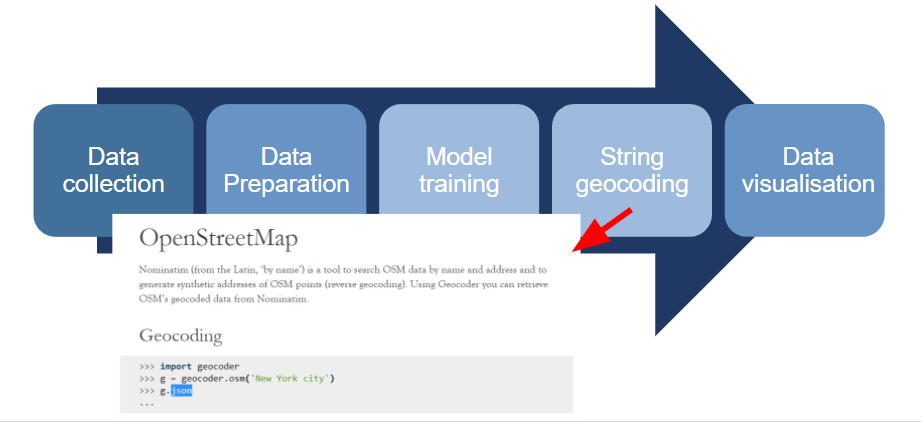

*Figure 7: String geocoding*

In [ ]:
# This function generates x,y coordinates based on the extracted location from the model.

def geocode_locations(processed_df, city, region, address_col):
    addresses = processed_df[address_col].apply(lambda x: x+f', {city} '+f', {region}') 
    chunk_size = 200
    chunks = len(processed_df[address_col])//chunk_size+1
    batch = list()
    for i in range(processed_df.shape[0]):
        batch.extend([geocoder.osm(addresses.iloc[i]).json])
    processed_df["gecoder_dict"] = batch 
    return processed_df

In [ ]:
# This takes to a little time to run
crime_df = geocode_locations(results, city='Madison', region='WI', address_col='Address')

2021-01-26 06:59:38.898 INFO    geocoder.base: Requested https://nominatim.openstreetmap.org/search?q=Pinewood+Court+apartment+building%2C+Madison+%2C+WI&format=jsonv2&addressdetails=1&limit=1
2021-01-26 06:59:39.804 INFO    geocoder.base: Requested https://nominatim.openstreetmap.org/search?q=700+block+of+Riverside+Drive%2C+Madison+%2C+WI&format=jsonv2&addressdetails=1&limit=1
2021-01-26 06:59:40.640 INFO    geocoder.base: Requested https://nominatim.openstreetmap.org/search?q=Bradbury+Rd.%2C+Madison+%2C+WI&format=jsonv2&addressdetails=1&limit=1
2021-01-26 06:59:41.503 INFO    geocoder.base: Requested https://nominatim.openstreetmap.org/search?q=Bradbury+Rd.%2C+Madison+%2C+WI&format=jsonv2&addressdetails=1&limit=1
2021-01-26 06:59:42.512 INFO    geocoder.base: Requested https://nominatim.openstreetmap.org/search?q=U.S.+Bank%2C+4602+East+Towne+Blvd.%2C+Madison+%2C+WI&format=jsonv2&addressdetails=1&limit=1
2021-01-26 06:59:43.395 INFO    geocoder.base: Requested https://nominatim.openst

In [ ]:
crime_df["lat"] = None
crime_df["long"] = None
crime_df["accuracy"] = None
crime_df["confidence"] = None

for index, geocoder_dict in enumerate(crime_df["gecoder_dict"].values):
  if geocoder_dict is not None:
    crime_df.loc[index, "lat"] = geocoder_dict["lat"]
    crime_df.loc[index, "long"] = geocoder_dict["lng"]
    crime_df.loc[index, "accuracy"] = geocoder_dict["accuracy"]
    crime_df.loc[index, "confidence"] = geocoder_dict["confidence"]

In [ ]:
crime_df

,TEXT,Filename,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon,gecoder_dict,lat,long,accuracy,confidence
0,Three roommates were robbed at gunpoint in the...,849.txt,Pinewood Court apartment building,"robbed,second weapon",early Sunday morning,08/28/2017,11:27 AM,PIO Joel Despain,,"{'accuracy': 0.51, 'address': 'Pinewood Court,...",43.1058,-89.309,0.51,10
1,An 18-year-old Madison man has reported an arm...,242.txt,700 block of Riverside Drive,"armed robbery,circling the block,stolen,posses...",early Tuesday morning,06/23/2016,12:59 PM,PIO Joel Despain,knife,None,None,None,None,None
2,He'd driven his Cadillac all the way from Flor...,1283.txt,Bradbury Rd.,scam,,04/19/2017,11:17 AM,PIO Joel Despain,,"{'accuracy': 0.41000000000000003, 'address': '...",43.014,-89.4858,0.41,9
3,He'd driven his Cadillac all the way from Flor...,1283.txt,Bradbury Rd.,scam,,04/19/2017,11:17 AM,PIO Joel Despain,,"{'accuracy': 0.41000000000000003, 'address': '...",43.014,-89.4858,0.41,9
4,The MPD detained a bank robbery suspect during...,1386.txt,"U.S. Bank, 4602 East Towne Blvd.",bank robbery,,12/13/2016,3:02 PM,PIO Joel Despain,weapon,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,"A Madison man, who has been arrested twice bef...",273.txt,Green's Petra Place apartment,drug,,05/23/2019,9:49 AM,PIO Joel Despain,,None,None,None,None,None
1844,The MPD responded to reports of multiple gun s...,1363.txt,700 block of N. Oak St.,multiple gun,early Sunday morning,10/03/2016,10:22 AM,PIO Joel Despain,,None,None,None,None,None
1845,The MPD arrested a 41-year-old Madison man for...,766.txt,Commercial Ave.,,Sunday afternoon,04/11/2016,3:28 PM,PIO Joel Despain,,"{'accuracy': 0.51, 'address': 'Commercial Aven...",43.1064,-89.3373,0.51,9
1846,The Madison Police Department was dispatched t...,397.txt,2700 block of Dryden Drive,"attempted strong armed robbery,demanded cash",,09/26/2018,1:27 AM,Lt. Daniel Nale,,None,None,None,None,None


In [ ]:
geocoded_crime_df = crime_df[crime_df['gecoder_dict'].notnull()]

In [ ]:
geocoded_crime_df

,TEXT,Filename,Address,Crime,Crime_datetime,Reported_date,Reported_time,Reporting_officer,Weapon,gecoder_dict,lat,long,accuracy,confidence
0,Three roommates were robbed at gunpoint in the...,849.txt,Pinewood Court apartment building,"robbed,second weapon",early Sunday morning,08/28/2017,11:27 AM,PIO Joel Despain,,"{'accuracy': 0.51, 'address': 'Pinewood Court,...",43.1058,-89.309,0.51,10
2,He'd driven his Cadillac all the way from Flor...,1283.txt,Bradbury Rd.,scam,,04/19/2017,11:17 AM,PIO Joel Despain,,"{'accuracy': 0.41000000000000003, 'address': '...",43.014,-89.4858,0.41,9
3,He'd driven his Cadillac all the way from Flor...,1283.txt,Bradbury Rd.,scam,,04/19/2017,11:17 AM,PIO Joel Despain,,"{'accuracy': 0.41000000000000003, 'address': '...",43.014,-89.4858,0.41,9
5,The MPD detained a bank robbery suspect during...,1386.txt,E. Washington Ave.,bank robbery,,12/13/2016,3:02 PM,PIO Joel Despain,weapon,"{'accuracy': 0.61, 'address': 'East Washington...",43.1304,-89.3047,0.61,8
6,The MPD detained a bank robbery suspect during...,1386.txt,Schmedeman Ave.,bank robbery,,12/13/2016,3:02 PM,PIO Joel Despain,weapon,"{'accuracy': 0.51, 'address': 'Schmedeman Aven...",43.1154,-89.327,0.51,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,At approximately 3:55 pm on today's date Madis...,171.txt,Upham St. and North St.,"disturbance,shot the suspect,shooting",3:55 pm,09/01/2018,5:49 PM,Lt. Jamar Gary,knife,"{'accuracy': 0.61, 'address': 'Upham Street, E...",43.1,-89.3565,0.61,10
1834,For one victim the crime brought back flashbac...,916.txt,S. Park St.,"sexual abuse,lewd and lascivious act",Thursday afternoon,04/05/2019,10:02 AM,PIO Joel Despain,,"{'accuracy': 0.61, 'address': 'South Park Stre...",43.0454,-89.3942,0.61,8
1837,"A Madison woman, who an arresting officer reco...",99.txt,East Towne Mall,"shoplifter,without paying",,03/19/2019,10:07 AM,PIO Joel Despain,,"{'accuracy': 0.71, 'address': 'East Towne Mall...",43.1251,-89.3047,0.71,8
1845,The MPD arrested a 41-year-old Madison man for...,766.txt,Commercial Ave.,,Sunday afternoon,04/11/2016,3:28 PM,PIO Joel Despain,,"{'accuracy': 0.51, 'address': 'Commercial Aven...",43.1064,-89.3373,0.51,9


In [ ]:
geocoded_crime_df.to_csv(r"madison-city-crime-df.csv")

# Spatial Visualisation

## Folium exploration

Folium is a popular sptial data visualisation module and is built on top of Leaflet.js. Although is covers most mapping needs it lacks the simplicity, interactivity, dynamism and aesthetically appealling nature of keplergl (in my opinion). 

Below are some examples of the visualisation techniques explored with folium.

In [ ]:
map1 = folium.Map(location=(43.0731, -89.4012), zoom_start=12)
for index,row in geocoded_crime_df.iterrows(): 
  # Add the geocoded locations to the map
  folium.Marker(location=(row['lat'],row['long']), popup=row['Address']).add_to(map1)

display(map1)

In [ ]:
from folium import plugins
from folium.plugins import HeatMap


map2 = folium.Map(location=(43.0731, -89.4012), zoom_start=12) 

# Ensure you're handing it floats
heat_df = geocoded_crime_df
heat_df['lat'] = heat_df['lat'].astype(float)
heat_df['long'] = heat_df['long'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = heat_df[['lat', 'long']]
heat_df = heat_df.dropna(axis=0, subset=['lat','long'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['long']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map2)
map2.add_child(folium.ClickForMarker(popup='Potential Location'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Adds tool to the top right
from folium.plugins import MeasureControl
map2.add_child(MeasureControl())

# Fairly obvious I imagine - works best with transparent backgrounds
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map2)

In [ ]:
# Display the map
map2

## kepler.gl

Kepler.gl is a relatively new geospatial mapping module developed by Uber. It is an open source module that was built on deck.gl. Its appeal lies in its ability to produce beautiful maps simply and quickly. This can be done either through use of it's online User interface (UI), or via python and Jupyter notebooks. Besides the aesthetically appealling maps it produces, kepler.gl was chosen as the mapping method for this project because it overcame the burdensome (and often tedious) task of having to program each widget and layer displayed (which can become extensive with geospatial data).Additionally the module supported data interactivety which was in line with one of the aims of my investigation - allowing users to draw insights.


In [ ]:
%%writefile geo_nlp_app.py
from PIL import Image
import streamlit as st
# import torch.nn as nn
# import torch
# from torch.nn.utils.rnn import pad_sequence
# from transformers import BertTokenizer, BertModel
# import spacy_streamlit
# import en_core_web_sm
import spacy
import io
from typing import List, Optional
import markdown
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pydeck as pdk
import numpy as np
import base64
import random
import streamlit.components.v1 as components

source_code = ""
# nlp = en_core_web_sm.load()
matplotlib.use("Agg")
COLOR = "black"
BACKGROUND_COLOR = "#fff"


menu = ["Home", "Geospatial NLP", "Get in Touch"]
side_bar_temp = """
                <style>
                .reportview-container .markdown-text-container {
                    font-family: monospace;
                }
                .sidebar .sidebar-content {
                    background-image: linear-gradient(#e3e3e3, #e3e3e3);
                    color: black;
                }
                .Widget>label {
                    color: black;
                    font-family: monospace;
                }
                [class^="st-b"]  {
                    color: black;
                    font-family: monospace;
                }
                .st-at {
                    background-color: white;
                }
                .st-dg {
                    background-color: #a6961f;
                }
                footer {
                    font-family: monospace;
                }
                .reportview-container .main footer, .reportview-container .main footer a {
                    color: black;
                }
                header .decoration {
                    background-image: none;
                }
                </style>
                """

safe_html = """ 
            <div style="background-color:#95ce1d;height:40px;width: 100%">
                <h2 style="color:white;text-align:center;"><b> Non-Toxic </b></h2>
            </div>
            """

danger_html = """  
              <div style="background-color:#ce1d1d;height:40px;width: 100%">
                <h2 style="color:white;text-align:center;"><b> Toxic </b></h2>
              </div>
              """

toxic_html = """  
              <div style="background-color:#ce1d1d;height:40px;width: 100%">
                <h2 style="color:white;text-align:center;"><b>Class 1: {}. Class 2: {}</b></h2>
              </div>
              """

white_space_html = """
                   <div style="background-color:white;height:40px;width: 100%"></div>
                   """

st.markdown(side_bar_temp, unsafe_allow_html=True,)
page = st.sidebar.markdown("""## Menu""")
page = st.sidebar.selectbox("", menu)


def select_block_container_style():
    """Add selection section for setting setting the max-width and padding
    of the main block container"""
    st.sidebar.header("Style Settings")
    max_width = 1200
    dark_theme = st.sidebar.checkbox("Dark Theme?", False)
    if dark_theme:
        global COLOR
        global BACKGROUND_COLOR
        BACKGROUND_COLOR = "rgb(17,17,17)"
        COLOR = "#fff"

    _set_block_container_style(
        max_width
    )


def _set_block_container_style(
        max_width: int = 1200,
        padding_top: int = 5,
        padding_right: int = 1,
        padding_left: int = 1,
        padding_bottom: int = 10,
):
    max_width_str = f"max-width: {max_width}px;"
    st.markdown(
        f"""
    <style>
        .reportview-container .main .block-container{{
            {max_width_str}
            padding-top: {padding_top}rem;
            padding-right: {padding_right}rem;
            padding-left: {padding_left}rem;
            padding-bottom: {padding_bottom}rem;
        }}
        .reportview-container .main {{
            color: {COLOR};
            background-color: {BACKGROUND_COLOR};
        }}
    </style>
    """,
        unsafe_allow_html=True,
    )


select_block_container_style()


def add_resources_section():
    """Adds a resources section to the sidebar"""
    st.sidebar.header("Contact Us")
    st.sidebar.markdown(
        """
        - Email: <a href="kelly@dsi-program.com">geospatial@nlp-solutions.com</a>
        - Location [Google Maps] (http://maps.google.com/?q=-34.107210,18.470510)
""",
        unsafe_allow_html=True,
    )


add_resources_section()

if page == "Home":
    html_temp = """
                <div style="background-color:{};padding:10px">
                <h1 style="color:{};text-align:center;">Geospatial Natural Language Processing</h1>
                </div>
                """
    st.markdown(html_temp.format("black", "#a6961f"), unsafe_allow_html=True)

    file_ = open(r"/content/drive/MyDrive/DSI Module 4/geospatial_nlp.gif", "rb")
    contents = file_.read()
    data_url = base64.b64encode(contents).decode("utf-8")
    file_.close()

    st.markdown(
        f'<img src="data:image/gif;base64,{data_url}" style="height:660px; width:1162px" alt="geospatial nlp gif">',
        unsafe_allow_html=True,
    )

if page == "Geospatial NLP":
    html_temp = """
                <div style="background-color:{};padding:10px">
                <h1 style="color:{};text-align:center;">Geospatial NLP</h1>
                </div>
                """
    st.markdown(html_temp.format("black", "#a6961f"), unsafe_allow_html=True)

    comment = st.text_area("Enter Your File Path Here")
    drop_box = st.file_uploader("Upload your file.")

    def color_gen():  # this function generates and returns a random color.
        random_number = random.randint(0, 16777215)  # 16777215 ~= 255x255x255(R,G,B)
        hex_number = format(random_number, 'x')
        hex_number = '#' + hex_number
        return hex_number

    HtmlFile = open(r"/content/drive/MyDrive/DSI Module 4/kepler.gl (8).html", 'r', encoding='utf-8')
    source_code = HtmlFile.read()
    print(source_code)
    components.html(source_code, height=500)

if page == "Benefits of NLP":

    html_temp = """
                <div style="background-color:{};padding:10px">
                <h1 style="color:{};text-align:center;">NLP for Business</h1>
                </div>
                """
    st.markdown(html_temp.format("black", "#a6961f"), unsafe_allow_html=True)

    class Cell:
        """A Cell can hold text, markdown, plots etc."""

        def __init__(
                self,
                class_: str = None,
                grid_column_start: Optional[int] = None,
                grid_column_end: Optional[int] = None,
                grid_row_start: Optional[int] = None,
                grid_row_end: Optional[int] = None,
        ):
            self.class_ = class_
            self.grid_column_start = grid_column_start
            self.grid_column_end = grid_column_end
            self.grid_row_start = grid_row_start
            self.grid_row_end = grid_row_end
            self.inner_html = ""

        def _to_style(self) -> str:
            return f"""
        .{self.class_} {{
            grid-column-start: {self.grid_column_start};
            grid-column-end: {self.grid_column_end};
            grid-row-start: {self.grid_row_start};
            grid-row-end: {self.grid_row_end};
        }}
        """

        def text(self, text: str = ""):
            self.inner_html = text

        def markdown(self, text):
            self.inner_html = markdown.markdown(text)

        def pyplot(self, fig=None, **kwargs):
            string_io = io.StringIO()
            plt.savefig(string_io, format="svg", fig=(2, 2))
            svg = string_io.getvalue()[215:]
            plt.close(fig)
            self.inner_html = '<div height="200px">' + svg + "</div>"

        def _to_html(self):
            return f"""<div class="box {self.class_}">{self.inner_html}</div>"""


    class Grid:
        """A (CSS) Grid"""

        def __init__(
                self,
                template_columns="1 1 1",
                gap="10px",
                background_color=COLOR,
                color=BACKGROUND_COLOR,
        ):
            self.template_columns = template_columns
            self.gap = gap
            self.background_color = background_color
            self.color = color
            self.cells: List[Cell] = []

        def __enter__(self):
            return self

        def __exit__(self, type, value, traceback):
            st.markdown(self._get_grid_style(), unsafe_allow_html=True)
            st.markdown(self._get_cells_style(), unsafe_allow_html=True)
            st.markdown(self._get_cells_html(), unsafe_allow_html=True)

        def _get_grid_style(self):
            return f"""
        <style>
            .wrapper {{
            display: grid;
            grid-template-columns: {self.template_columns};
            grid-gap: {self.gap};
            background-color: {self.background_color};
            color: {self.color};
            }}
            .box {{
            background-color: {self.color};
            color: {self.background_color};
            border-radius: 5px;
            padding: 20px;
            font-size: 150%;
            }}
            table {{
                color: {self.color}
            }}
        </style>
        """

        def _get_cells_style(self):
            return (
                    "<style>"
                    + "\n".join([cell._to_style() for cell in self.cells])
                    + "</style>"
            )

        def _get_cells_html(self):
            return (
                    '<div class="wrapper">'
                    + "\n".join([cell._to_html() for cell in self.cells])
                    + "</div>"
            )

        def cell(
                self,
                class_: str = None,
                grid_column_start: Optional[int] = None,
                grid_column_end: Optional[int] = None,
                grid_row_start: Optional[int] = None,
                grid_row_end: Optional[int] = None,
        ):
            cell = Cell(
                class_=class_,
                grid_column_start=grid_column_start,
                grid_column_end=grid_column_end,
                grid_row_start=grid_row_start,
                grid_row_end=grid_row_end,
            )
            self.cells.append(cell)
            return cell

    with Grid("1 1 1", color=COLOR, background_color=BACKGROUND_COLOR) as grid:
        grid.cell(
            class_="a",
            grid_column_start=2,
            grid_column_end=3,
            grid_row_start=1,
            grid_row_end=2,
        ).markdown("Faster response and decision making")
        grid.cell("b", 2, 3, 2, 3).text("Improved levels of engagement")
        grid.cell("c", 3, 4, 2, 3).text("Stronger Alignment with strategic objectives")
        grid.cell("d", 1, 2, 1, 3).text("Better engagement")
        grid.cell("e", 3, 4, 1, 2).markdown(
            "Better costumer understanding"
        )
        grid.cell("f", 1, 3, 3, 4).markdown(
            "# NLP SOLUTIONS"
        )
        grid.cell("g", 3, 4, 3, 4).text("Increased sales")

if page == "Get in Touch":
    html_temp = """
                <div style="background-color:{};padding:10px">
                <h1 style="color:{};text-align:center;">Contact Us</h1>
                </div>
                """
    st.markdown(html_temp.format("black", "#a6961f"), unsafe_allow_html=True)

    data = pd.DataFrame({
        'awesome cities': ['KAN NLP Solutions'],
        'lat': [-34.107210],
        'lon': [18.470510]
    })

    st.pydeck_chart(pdk.Deck(
        map_style='mapbox://styles/mapbox/light-v9',
        initial_view_state=pdk.ViewState(
            latitude=-34.107210,
            longitude=18.470510,
            zoom=11,
            pitch=0,
        ),
        layers=[
            pdk.Layer(
               'HexagonLayer',
               data=data,
               get_position='[lon, lat]',
               radius=200,
               elevation_scale=4,
               elevation_range=[0, 1000],
               pickable=True,
               extruded=True,
            ),
            pdk.Layer(
                'ScatterplotLayer',
                data=data,
                get_position='[lon, lat]',
                get_color='[200, 30, 0, 160]',
                get_radius=200,
            ),
        ],
    ))

Writing geo_nlp_app.py


In [ ]:
!streamlit run geo_nlp_app.py &>/dev/null&

In [ ]:
!ngrok authtoken 1k7LuwPEr52p9mxKNLJMMyc2MPY_2jmuv2LKwaujvNSPWyvjo

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
print(ngrok.__version__)

4.1.1


In [ ]:
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='8501')
public_url

In [ ]:
!ps -eaf | grep streamlit

root         911       1 38 10:06 ?        00:00:06 /usr/bin/python3 /usr/local/bin/streamlit run nlp_app.py
root         956     880  0 10:06 ?        00:00:00 /bin/bash -c ps -eaf | grep streamlit
root         958     956  0 10:06 ?        00:00:00 grep streamlit


In [ ]:
!pgrep streamlit

911


In [ ]:
!kill 763

In [ ]:
ngrok.kill()

# Conclusion

This notebook covered the entire geospatial nlp process including model building, entity extraction, geocoding and spatial visualisation. 

Upon evaluating the models on test data, they performed really well with recall, precision and f1 all having a score of 1, even at the class level. 

Despite this after a quick evaluation of some of the records revealed mislabelling. This error could be attrinuted to the incorrect classification of the training data, which could have easily arose as I relied on the accuracy of the inherent labels in the data. This could have resulted in an issue because correctly labelld data is essential for the model to learn the correct features and for improving classification performace

The geocoding however did not perform as well as the model. The accuracy range between 0.3-0.9 (with a score of 1 being a high accuracy) with most of the values falling in the lower end of the range. The geocoder confidence score faired slightly better with a range between 4-10, wwith most of the values falling in the upper end of the range.

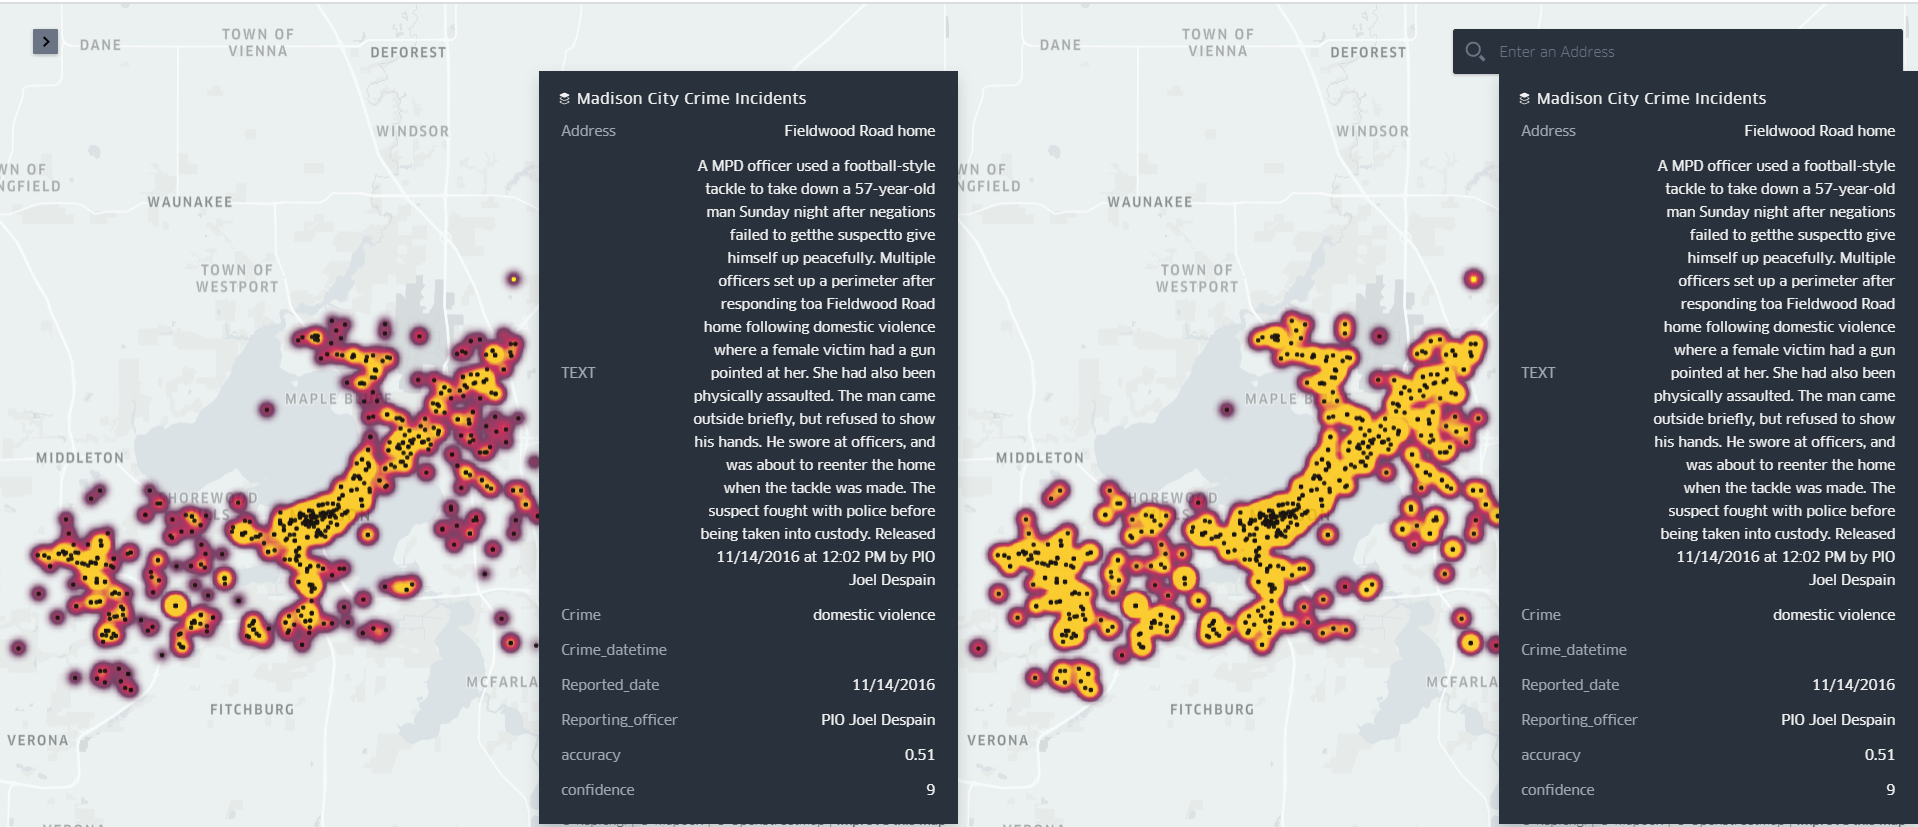
*Figure 8 : Heatmap of the accuracy and confidence of the geocoding. Geocoding accuracy on the right and geocoding confidence on the left*


 


However, as with any scientific endeavor improvements can be made. These improvements are detailed in the section below.

### Recommendations and Future Work



* Increase the dataset

* Implement additional labels

* Implement sematic analysis to broaden the scope of the project and garner a greater insights

*   Improve integration between the different facets of project

* Improve the overall run time

* Check the labelling of the data or label data myself (either automatically or manually)

* Explore other geocoding methods







# Appendices

## Journey

### Kelly 
Although a project I got to pick for myself this was by no means an easy one. It pushed me to learn about not only geospatial NLP and all the facets involved, but to seek out tools and methods that were best suited to the task at hand. 

Working on the project by myself was surely daunting, but with the support of my tutor and other DSI participate I felt heard and encouraged. Above all this task taught me about, asking for help when needed and about having confidence in my skills. 

As I work in the GIS (Geographic Information SYstems) field, I am sure that the knowldge I have gained in this task will be used to inform my work down the line.


## References



[1] Chowdhury, G.G., 2003. Natural language processing. Annual review of information science and technology, 37(1), pp.51-89.

[2] https://developers.arcgis.com/python/sample-notebooks/information-extraction-from-madison-city-crime-incident-reports-using-deep-learning/?adumkts=product&aduc=pr&adum=blogs&utm_Source=pr&aduca=mi_sads_capability_promotions&aduco=geospatial-natural-language-processing-medium-article&aduat=article&adupt=lead_gen&sf_id=7015x000000iSB6AAM

[3] https://developers.arcgis.com/python/guide/how-named-entity-recognition-works/

[4] https://medium.com/geoai/geospatial-natural-language-processing-ee3fc6ea6939

[5] https://developers.arcgis.com/python/sample-notebooks/analyzing-violent-crime/

[6] https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/

[7] https://www.analyticsvidhya.com/blog/2020/06/learn-visualize-geospatial-data-jupyter-kepler/?utm_source=blog&utm_medium=guide-geospatial-analysis-folium-python
